In [68]:
import torch, torchvision
from torch.utils.data import Subset
import torchvision.models as models
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

# Configure Experiment

In [101]:
config = {
    'experiment_name': 'identity',
    'lr': 0.01,
    'batch_size': 64,
    'epochs':10,
    'val_epochs': 2,
    'cpt_epochs': [3,6,9],
    'freeze_layers':False
}

In [ ]:
no_augment = []
crop_augment = [transforms.CenterCrop(10)]

identity_augment = [
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]

# Change to augment_XYZ + identity_augment
augmentation = transforms.Compose(no_augment + identity_augment)

# Initialize model and load data

In [71]:
# Make directories to save stuff
pathlib.Path('cpts').mkdir(exist_ok=True) 
pathlib.Path('plots').mkdir(exist_ok=True) 
pathlib.Path('preds').mkdir(exist_ok=True) 

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert(device=='cuda')

In [58]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.to(device)

In [102]:
if config['freeze_layers']:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    # for param in model.layer4.parameters():
    #     param.requires_grad = True

In [62]:
cifar_train = torchvision.datasets.CIFAR10("CIFAR_train", train=True, download=True, transform=augmentation)
cifar_test = torchvision.datasets.CIFAR10("CIFAR_test", train=False, download=True, transform=transforms.Compose(identity_augment))
len(cifar_train), len(cifar_test)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [63]:
trainloader = torch.utils.data.DataLoader(cifar_train,
                                          batch_size=config['batch_size'],
                                          shuffle=False,
                                          num_workers=1)
testloader = torch.utils.data.DataLoader(cifar_test,
                                          batch_size=config['batch_size'],
                                          shuffle=False,
                                          num_workers=1)    

# Training

In [85]:
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'])
crit = torch.nn.CrossEntropyLoss()
train_losses = []
val_losses = []

for epoch in range(config['epochs']):
  tq = tqdm.tqdm(trainloader)
  
  train_loss_sum = 0

  val_loss_sum = 0


  for (data, gt) in tq:
    data = data.to(device)
    gt = gt.to(device)
    with torch.enable_grad():
      pred = model(data)
      loss = crit(pred, gt)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_sum += loss

  
  # val
  if epoch % config['val_epochs'] == 0:
    for (data,gt) in testloader:
      data = data.to(device)
      gt = gt.to(device)
      pred = model(data)
      loss = crit(pred,gt)
      val_loss_sum+=loss
      
    val_loss_avg = val_loss_sum / len(testloader)
    val_losses.append(val_loss_avg.item())

  if epoch in config['cpt_epochs']:
    torch.save(model.state_dict(), f"cpts/{config['experiment_name']}-ep{epoch}")

  train_loss_avg = train_loss_sum / len(trainloader)
  train_losses.append(train_loss_avg.item())
  print(f"Train loss: {train_loss_avg} Val loss: {val_loss_avg}")

100%|██████████| 782/782 [00:28<00:00, 27.06it/s]


Train loss: 0.9460272192955017 Val loss: 0.9962000846862793


100%|██████████| 782/782 [00:29<00:00, 26.73it/s]


Train loss: 0.8067780137062073 Val loss: 0.9962000846862793


100%|██████████| 782/782 [00:28<00:00, 27.01it/s]


Train loss: 0.7229468822479248 Val loss: 0.8369650840759277


100%|██████████| 782/782 [00:28<00:00, 27.12it/s]


Train loss: 0.6465048789978027 Val loss: 0.8369650840759277


 60%|█████▉    | 468/782 [00:17<00:11, 26.94it/s]


KeyboardInterrupt: ignored

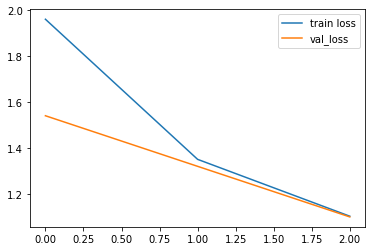

In [83]:
fig1 = plt.gcf()
plt.plot(train_losses, label='train loss')
plt.plot(np.arange(0,config['val_epochs']*len(val_losses),config['val_epochs']),val_losses, label='val_loss')
plt.legend()
fig1.show()

In [ ]:
preds = []
gts = []
for (X,y) in tqdm.tqdm(testloader):
  X = X.to(device)
  yhat = model(X).argmax(axis=1).tolist()
  preds += yhat
  gts += y.tolist()
preds = np.array(preds)
gts = np.array(gts)

100%|██████████| 157/157 [00:04<00:00, 38.25it/s]


In [88]:
(preds==gts).mean()

0.7348

## Save plots and predictions

In [94]:
with open(f"preds/{config['experiment_name']}.npy",'wb') as outfile:
  np.save(outfile,preds)

In [84]:
fig1.savefig(f"plots/{config['experiment_name']}.jpg")